# Example: JUSTICE - IAM Simulation Run

In [1]:
import pandas as pd
import numpy as np

from src.data_loader import DataLoader
from src.enumerations import *
from src.model_time import TimeHorizon
from src.model import JUSTICE

### Setting Some Dummy Policy Levers

#### Lever: Fixed Savings rate

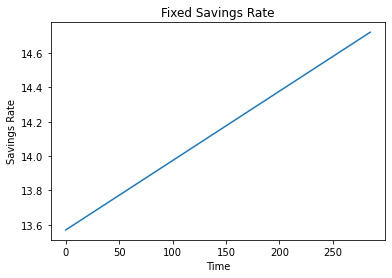

(57, 286)


In [2]:
# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

#Create a fixed savings rate
fixed_savings_rate = np.copy(data_loader.SAVING_RATE_INIT_ARRAY).reshape(-1, 1)
#fixed_savings_rate Validated with RICE50 for timestep 1 and 5

set_year = time_horizon.model_time_horizon
#economy.get_optimal_long_run_savings_rate() = 0.2582781457 #This needs the economy module to be instantiated

for i, years in enumerate(set_year):
    
    t = i+1 #index starts at 0, so add 1 to get the year

    if t != 1: # no need to repeat for the first year

        next_rate = data_loader.SAVING_RATE_INIT_ARRAY + (0.2582781457  - data_loader.SAVING_RATE_INIT_ARRAY)*((t - 1)/(len(set_year) - 1))
        # append to the fixed savings rate array for each year
        fixed_savings_rate = np.column_stack((fixed_savings_rate, next_rate))

from matplotlib import pyplot as plt
plt.plot(np.sum(fixed_savings_rate, axis=0))
plt.title("Fixed Savings Rate")
plt.xlabel("Time")
plt.ylabel("Savings Rate")
plt.show()
print(fixed_savings_rate.shape)

In [3]:
# Save fixed savings rate as a csv file using pandas

# df = pd.DataFrame(fixed_savings_rate)
# df.to_csv('config/savings_rate_fixed.csv', index=False)
# Find the minimum savings rate
print("Minimum savings rate: ", np.min(fixed_savings_rate))

Minimum savings rate:  0.09317


#### Lever: Linear Emissions Control Rate

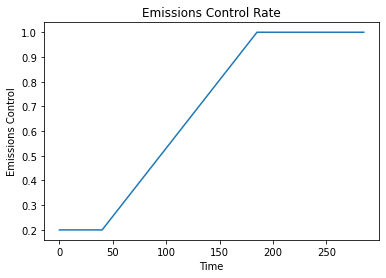

In [3]:
#emissions control rate borrowed from emissions module

#Variables to be changed/deleted later
miu_initial = 0.0
min_miu = 0.2 #0.0 #1.0
min_miu_year = 2055 #9-original #8 in this model  # 2060
max_miu = 1.0 #1.2
max_miu_year = 2200 #38-original #37 in this model #2205

t_min_miu = time_horizon.year_to_timestep(min_miu_year, timestep=1)
t_max_miu = time_horizon.year_to_timestep(max_miu_year, timestep=1)

#Initialize emissions control rate
emissions_control_rate = np.zeros((len(data_loader.REGION_LIST), len(time_horizon.model_time_horizon)))

for t in range(len(time_horizon.model_time_horizon)):
    
    if t < t_min_miu:       # Before time of transition
        emissions_control_rate[:,t] = min_miu
    elif t <= t_max_miu:   # Transition
        # During the transition
        emissions_control_rate[:, t] = min_miu + (max_miu - min_miu) * (t - t_min_miu)/(t_max_miu - t_min_miu)
    else:                   # After the transition
        emissions_control_rate[:, t] = max_miu


from matplotlib import pyplot as plt
plt.plot(emissions_control_rate[0, :])
plt.title("Emissions Control Rate")
plt.xlabel("Time")
plt.ylabel("Emissions Control")
plt.show()

In [5]:
# Save emissions control rate as a csv file using pandas

df = pd.DataFrame(emissions_control_rate)
df.to_csv('config/emissions_control_rate_linear.csv', index=False)

## 1. JUSTICE Initialisation

In [4]:
# Get list of Scenarios from Enum

for idx, scenarios in enumerate(list(Scenario.__members__.keys())):
    print(idx, scenarios)

0 SSP119
1 SSP126
2 SSP245
3 SSP370
4 SSP434
5 SSP460
6 SSP534
7 SSP585


In [5]:
scenarios = 7
model = JUSTICE(
        
        start_year = 2015,
        end_year = 2300,
        timestep = 1,
        scenario =scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
    )

## 2. Run

In [6]:
model.run(savings_rate = fixed_savings_rate, emissions_control_rate = emissions_control_rate)

## 3. Evaluate - SWF - and Generated Output Datasets

In [7]:
datasets = model.evaluate(welfare_function=WelfareFunction.UTILITARIAN, elasticity_of_marginal_utility_of_consumption = 1.45, pure_rate_of_social_time_preference = 0.015, inequality_aversion = 0.5)

print(model.get_outcome_names())

dict_keys(['net_economic_output', 'consumption', 'consumption_per_capita', 'emissions', 'regional_temperature', 'global_temperature', 'economic_damage', 'abatement_cost', 'carbon_price', 'disentangled_utility', 'welfare_utilitarian'])


In [8]:
net_output = datasets['net_economic_output']
consumption = datasets['consumption'] #(57, 286, 1001)
cpc = datasets['consumption_per_capita'] #(57, 286, 1001)
emis = datasets['emissions'] #(57, 286, 1001)
reg_temp = datasets['regional_temperature']
temp = datasets['global_temperature'] # (286, 1001)
damages = datasets['economic_damage'] #(57, 286, 1001)
abatecost = datasets['abatement_cost'] #(57, 286, 1001)
dis_util = datasets['disentangled_utility'] #(57, 286, 1001)
util = datasets['welfare_utilitarian'] # (286, 1001)



In [10]:
len(util.shape)
mean_util =  np.mean(util, axis=1)

In [14]:
# test_mean_temp = np.mean(temp, axis=1) #np.mean(results, axis=2)
util_sum = np.sum(dis_util, axis=0)
# util_sum = np.sum(util_sum, axis=0)

In [ ]:
# Assuming U, E, and C are your utility, emission, and consumption 3D numpy arrays...

# Prepare zero-filled 3D arrays for storing the results of gradient operations
# eq_E_m = np.zeros_like(cpc)
# eq_cc_m = np.zeros_like(cpc)

# # Calculate derivatives 
# eq_E_m = np.diff(dis_util, axis=1) / np.diff(emis, axis=1)
# eq_cc_m = np.diff(dis_util, axis=1) / np.diff(consumption, axis=1)

# # # Perform the operations slice by slice in a loop
# for i in range(cpc.shape[2]):
#     eq_E_m[:, :, i] = np.gradient(dis_util[:, :, i], emis[:, :, i], axis=1, edge_order=2)
#     eq_cc_m[:, :, i] = np.gradient(dis_util[:, :, i], consumption[:, :, i], axis=1, edge_order=2)

# # Calculate SCC
# SCC = -1000 * eq_E_m / eq_cc_m

# Sum up all the regions resulting in a 2D array (time, scenarios) for each variable
# dis_util_sum = np.sum(dis_util, axis=0)
# emis_sum = np.sum(emis, axis=0)
# cpc_sum = np.sum(cpc, axis=0)

# # Create zero-filled 2D arrays for storing the results of gradient operations
# eq_E_m = np.zeros_like(dis_util_sum)
# eq_cc_m = np.zeros_like(dis_util_sum)

# # Compute the derivatives for each scenario over time using np.gradient
# for i in range(dis_util_sum.shape[1]):  # Loop over scenarios
#     eq_E_m[:, i] = np.gradient(dis_util_sum[:, i], emis_sum[:, i], edge_order=2)
#     eq_cc_m[:, i] = np.gradient(dis_util_sum[:, i], cpc_sum[:, i], edge_order=2)

# # Calculate SCC
# SCC = -1000 * eq_E_m / eq_cc_m

In [ ]:
testdf = dis_util[:,:,0]

# Sum the testdf for all regions
#testdf = np.sum(testdf, axis=0)

In [ ]:
#damagedf = damages[:,:,0]
# time_horizon.model_time_horizon

## 4. Visualize

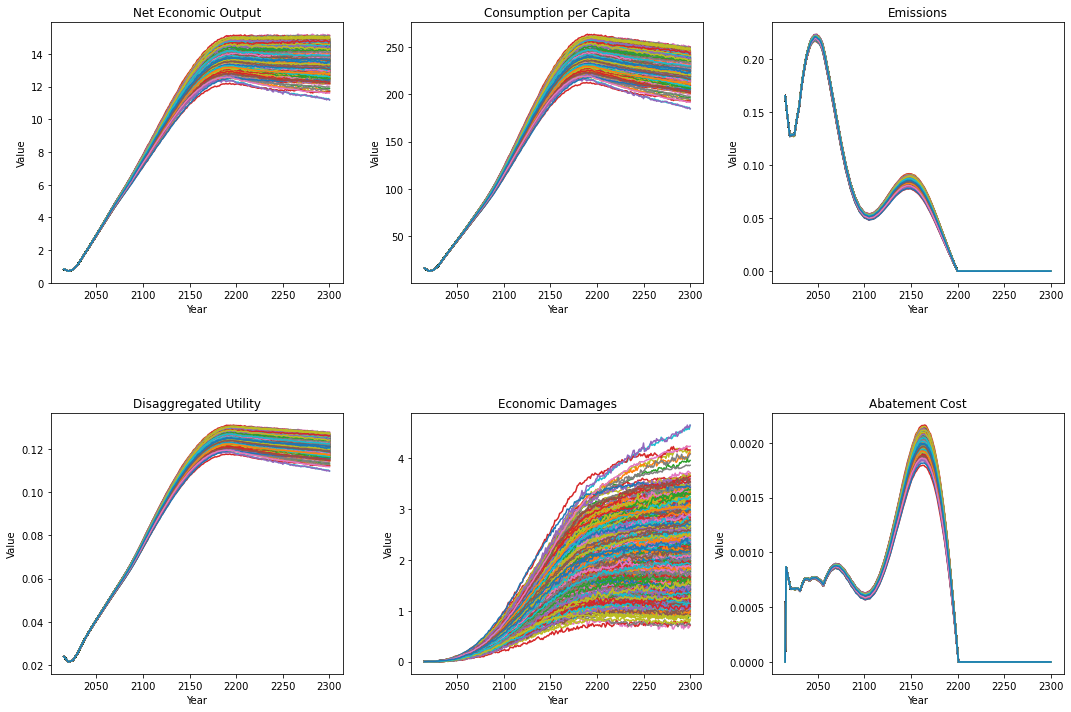

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create list of all the data arrays
data_list = [net_output, cpc, emis, dis_util, damages, abatecost]
titles = ['Net Economic Output', 'Consumption per Capita', 'Emissions', 'Disaggregated Utility', 'Economic Damages', 'Abatement Cost']

region_index = 0

# Create a figure with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Iterate over the data arrays and plot them
for i, data in enumerate(data_list):
    # Select the region based on region_index
    region_data = data[region_index, :, :]
    
    # Create a line plot for each scenario
    for j in range(region_data.shape[1]):
        sns.lineplot(x=time_horizon.model_time_horizon, y=region_data[:, j], ax=axs[i])
    
    # Set the title and axis labels
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Value')
    
# Remove the unused subplots
for i in range(len(data_list), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)





## Run All Scenarios

In [ ]:
# Create a dictionary to store the data for each scenario
scenario_data = {}


for idx, scenarios in enumerate(list(Scenario)):
    print(idx, scenarios)
    
    # Initialize the model
    model = JUSTICE(
        
        start_year = 2015,
        end_year = 2300,
        timestep = 1,
        scenario =scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
    )
    
    # Run the model
    model.run(savings_rate = fixed_savings_rate, emissions_control_rate = emissions_control_rate)

    # Evaluate the model
    scenario_data[scenarios] = model.evaluate(welfare_function=WelfareFunction.UTILITARIAN)


## EMA Workbench Tests

In [1]:
from analysis.analyzer import perform_exploratory_analysis

In [2]:
perform_exploratory_analysis(number_of_experiments=2)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 2 scenarios * 2 policies * 1 model(s) = 4 experiments
100%|████████████████████████████████████████████| 4/4 [00:49<00:00, 12.33s/it]
[MainProcess/INFO] experiments finished
/Users/palokbiswas/miniforge3/lib/python3.9/site-packages/ema_workbench/em_framework/outcomes.py:509: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")
[MainProcess/INFO] results saved successfully to /Users/palokbiswas/Desktop/pollockdevis_git/JUSTICE/data/output/results_open_exploration_2_median
[MainProcess/INFO] terminating pool


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ema_workbench import load_results, ema_logging
from ema_workbench.analysis.pairs_plotting import pairs_lines, pairs_scatter, pairs_density

ema_logging.log_to_stderr(level=ema_logging.DEFAULT_LEVEL)

# load the data
fh = "./data/output/results_open_exploration_1000_mean"
experiments, outcomes = load_results(fh)


[MainProcess/INFO] results loaded successfully from /Users/palokbiswas/Desktop/pollockdevis_git/JUSTICE/data/output/results_open_exploration_1000_mean


In [3]:
experiments.head()
# Keep the first 3 columns and the last 3 columns
experiments = experiments.iloc[:, [0, 1, 2, -3, -2, -1]]

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select a region
region_index = 0

# Extract and reshape the emissions for the selected region
emissions_data = outcomes['global_temperature'][:, region_index, :]

# Prepare for DataFrame creation
# We will have scenarios as rows, timesteps as columns and emissions as values
scenarios = emissions_data.shape[0]
timesteps = emissions_data.shape[1]
emissions_values = emissions_data.flatten()
scenario_values = [i for i in range(scenarios) for _ in range(timesteps)]
timestep_values = list(range(timesteps)) * scenarios

# Create DataFrame
df = pd.DataFrame({
    'scenario': scenario_values,
    'time': timestep_values,
    'emission': emissions_values
})

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=df, x='time', y='emission', hue='scenario', palette='tab10', ax=ax)

# Tune the plot
ax.set_title('Emissions over Time for Different Scenarios')
ax.set_xlabel('Time')
ax.set_ylabel('Emissions')
plt.legend(title='Scenarios')
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [6]:
# pairs_scatter(experiments, tr, filter_scalar=False)
# pairs_lines(experiments, outcomes)
# pairs_density(experiments, tr, filter_scalar=False)
# plt.show()


# outcomes = pd.DataFrame(outcomes)
# outcome_names = get_outcome_names()

# plot_pathways(outcomes, outcome_names)

# from ema_workbench.analysis import pairs_plotting

# fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by="policy", legend=False) #
# fig.set_size_inches(18, 18)
# plt.show()

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp



sns.pairplot(pd.DataFrame.from_dict(outcomes))

plt.show()

ValueError: Per-column arrays must each be 1-dimensional

In [5]:
import pandas as pd
experiments_df = pd.DataFrame(experiments)
experiments_df.head()

,elasticity_of_marginal_utility_of_consumption,inequality_aversion,pure_rate_of_social_time_preference,ssp_rcp_scenario,emissions_control_rate 0 0,emissions_control_rate 0 1,emissions_control_rate 0 10,emissions_control_rate 0 100,emissions_control_rate 0 101,emissions_control_rate 0 102,...,savings_rate 9 93,savings_rate 9 94,savings_rate 9 95,savings_rate 9 96,savings_rate 9 97,savings_rate 9 98,savings_rate 9 99,scenario,policy,model
0,1.435916,1.582470,0.001917,2,0.164482,0.660204,0.160120,0.939045,0.465165,0.532021,...,0.111660,0.430364,0.318989,0.277612,0.183043,0.297817,0.395044,2,0,JUSTICE
1,0.059007,0.988284,0.019733,4,0.164482,0.660204,0.160120,0.939045,0.465165,0.532021,...,0.111660,0.430364,0.318989,0.277612,0.183043,0.297817,0.395044,3,0,JUSTICE
2,1.435916,1.582470,0.001917,2,0.526896,0.434466,0.505765,0.007800,0.508756,0.294497,...,0.328374,0.191157,0.254893,0.234969,0.401937,0.205282,0.126866,2,1,JUSTICE
3,0.059007,0.988284,0.019733,4,0.526896,0.434466,0.505765,0.007800,0.508756,0.294497,...,0.328374,0.191157,0.254893,0.234969,0.401937,0.205282,0.126866,3,1,JUSTICE


In [5]:
outcomes_array = outcomes['disentangled_utility']

# compute the mean across the scenarios
mean_arr = np.mean(outcomes_array, axis=0)

# let's define n as the amount of close scenarios you'd like to select
n = 10

# compute the difference between each scenario and the mean
diff = outcomes_array - mean_arr

# compute the "distance" to the mean
distances = np.linalg.norm(diff, axis=(1,2))

# get the indices of the n scenarios with smallest distances
# here, np.argsort returns the indices that would sort the distances
# we are interested in the first n of these (the ones with smallest distance)
closest_indices = np.argsort(distances)[:n]

print(f"The scenarios that are closest to the mean are at indices {closest_indices} out of 2000.")

# # compute the difference between each scenario and the mean
# diff = outcomes_array - mean_arr

# # Now we want to compute the "distance" to the mean, we can use Euclidean distance as a measure
# distances = np.linalg.norm(diff, axis=(1,2))

# # the scenario that represents the mean is the one with the smallest distance
# index = np.argmin(distances)

# print(f"The scenario that represents the mean is at index {index} out of 2000.")

# # sum the utility for all regions
# # outcomes_array = np.sum(outcomes_array, axis=1)
# # mean_util = np.mean(outcomes_array, axis=0)
# median_util = np.median(outcomes_array, axis=0)
# #95th percentile
# p95_util = np.percentile(outcomes_array, 95, axis=0)
# #5th percentile
# p5_util = np.percentile(outcomes_array, 5, axis=0)

# # Sum the utility for all regions
# mean_util = np.sum(mean_util, axis=0)
# median_util = np.sum(median_util, axis=0)
# #95th percentile
# p95_util = np.sum(p95_util, axis=0)
# #5th percentile
# p5_util = np.sum(p5_util, axis=0)


# Plot the mean, median, 5th and 95th percentile. Array is of shape (57, 286). 286 are the timesteps. 57 are the scenarios
# plt.plot(mean_util, label='Mean')
# plt.plot(median_util, label='Median')
# plt.plot(p95_util, label='95th Percentile')
# plt.plot(p5_util, label='5th Percentile')
# plt.xlabel('Time')
# plt.ylabel('Utility')
# plt.title('Utility over Time')
# plt.legend()
# plt.show()


The scenarios that are closest to the mean are at indices [ 641  488    0 1641 1000 1488  959  155  841 1959] out of 2000.


In [10]:
# Get experiments at index 
selected_exp = experiments.iloc[index]
selected_exp.head()

elasticity_of_marginal_utility_of_consumption    0.284334
inequality_aversion                              0.547238
pure_rate_of_social_time_preference              0.006556
ssp_rcp_scenario                                        6
emissions_control_rate 0 0                        0.44417
Name: 641, dtype: object

In [6]:
testdf = np.sum(outcomes_array[0,:,:], axis=0)

In [9]:
dis_util = outcomes['disentangled_utility']

In [10]:
experiments.head()

,elasticity_of_marginal_utility_of_consumption,inequality_aversion,pure_rate_of_social_time_preference,scenario,policy,model
0,0.645823,0.475715,0.005461,2,0,JUSTICE
1,0.219590,0.607285,0.014588,3,0,JUSTICE
2,0.347389,0.755561,0.003625,4,0,JUSTICE
3,1.043104,1.117056,0.012482,5,0,JUSTICE
4,1.268521,0.703621,0.018964,6,0,JUSTICE


In [8]:
# Calculating Welfare:
    # Calculate the discount rate



def calculate_welfare(pure_rate_of_social_time_preference, inequality_aversion, elasticity_of_marginal_utility_of_consumption, disentangled_utility, timestep_list):

    print(pure_rate_of_social_time_preference, inequality_aversion, elasticity_of_marginal_utility_of_consumption)
    discount_rate = 1 / (
        np.power(
            (1 + pure_rate_of_social_time_preference),
            (time_horizon.timestep * (timestep_list)),
        )
    )
    print(discount_rate)
    disentangled_utility_summed = np.sum(
        disentangled_utility, axis=0
    )

    disentangled_utility_powered = np.power(
        disentangled_utility_summed,
        (
            (1 - elasticity_of_marginal_utility_of_consumption)
            / (1 - inequality_aversion)
        ),
    )

    welfare_utilitarian = np.sum(
        (
            (
                disentangled_utility_powered
                / (1 - elasticity_of_marginal_utility_of_consumption)
            )
            - 1
        )
        * discount_rate,
        axis=0,
    )

    return welfare_utilitarian

from src.model_time import TimeHorizon

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

timestep_list = np.arange(
    0, len(time_horizon.model_time_horizon), time_horizon.timestep
)

In [16]:
# Calculate welfare by iterating through the dis_util array and experiments dataframe

# iterate through the dis_util array first index

for i in range(experiments.shape[0]):
    # iterate through the experiments dataframe
    # for j in range(experiments.shape[0]):
        # Calculate welfare
    welfare_utilitarian = calculate_welfare(
        pure_rate_of_social_time_preference = experiments.iloc[i]['pure_rate_of_social_time_preference'],
        inequality_aversion=experiments.iloc[i]['inequality_aversion'],
        elasticity_of_marginal_utility_of_consumption=experiments.iloc[i]['elasticity_of_marginal_utility_of_consumption'],
        disentangled_utility = dis_util[i, :, :],
        timestep_list=timestep_list,
    )
    print (welfare_utilitarian)
    if i == 2:
        break
    # # Append the welfare_utilitarian to the experiments dataframe
    # experiments.at[j, 'welfare_utilitarian'] = welfare_utilitarian 



None
None
None


In [14]:
experiments.iloc[0]['pure_rate_of_social_time_preference'],

(0.0054607171937009,)